In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
filename = 'data/2018-01-01-2022-01-01.bin'
cols_to_drop = ['subba-name', 'parent', 'parent-name', 'value-units']
dtypes = {'period': 'datetime64',
          'subba': 'category',
          'timezone': 'category',
          'value': 'int64'}
df = pd.read_pickle(filename).drop(columns=cols_to_drop)
df = df.drop_duplicates().dropna().reset_index(drop=True)
df = df.astype(dtypes)
df = df[df['subba'] == 'ZONJ']
print('df shape:', df.shape)
print(df.head(1))
print(df.tail(1))

df shape: (6356, 4)
        period subba timezone   value
244 2022-01-01  ZONJ  Pacific  111015
           period subba timezone   value
494912 2018-06-26  ZONJ  Arizona  154798


In [3]:
filt = df.value == 0
to_drop = df[filt].index
df = df.drop(index=to_drop).reset_index(drop=True)

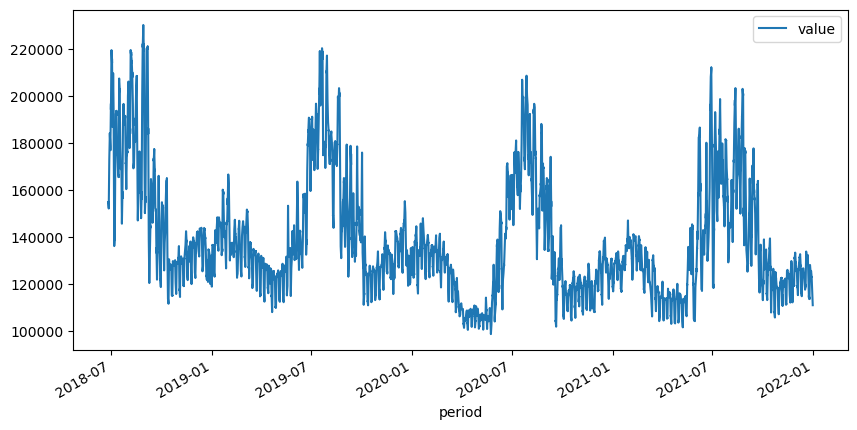

In [4]:
df.sort_values(by='period').plot(x='period', y='value', figsize=(10, 5));

         period subba  timezone   value
0    2022-01-01  ZONJ   Pacific  111015
1    2022-01-01  ZONJ   Arizona  111176
2    2022-01-01  ZONJ   Central  111354
3    2022-01-01  ZONJ  Mountain  111176
4    2022-01-01  ZONJ   Eastern  111503
...         ...   ...       ...     ...
6351 2018-06-26  ZONJ   Pacific  154798
6352 2018-06-26  ZONJ  Mountain  154792
6353 2018-06-26  ZONJ   Eastern  154928
6354 2018-06-26  ZONJ   Central  154836
6355 2018-06-26  ZONJ   Arizona  154798

[6045 rows x 4 columns]


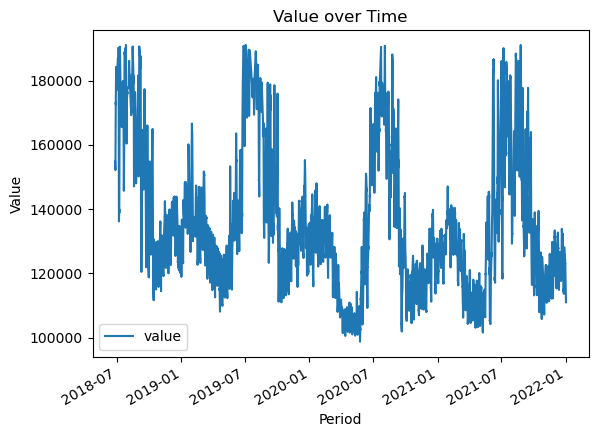

In [5]:
# Compute the IQR for the "value" column
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the acceptable range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows where the value in the "value" column is outside the bounds
df_filtered = df[(df['value'] >= lower_bound) & (df['value'] <= upper_bound)]

print(df_filtered)

# Plotting
df_filtered.plot(x='period', y='value', kind='line')

plt.xlabel('Period')
plt.ylabel('Value')
plt.title('Value over Time')
plt.show()

In [6]:
# Sort df by date in ascending order
df_sorted = df.sort_values(by=['period']).reset_index(drop=True)

In [7]:
def transform_to_supervised(df):
    orig = df.value
    shifted = df.value.shift()
    remaining = df.drop(columns=['value'])
    columns = ['period', 'subba', 'timezone', 'lag', 'value']
    
    transformed = pd.concat((remaining, shifted, orig), axis=1).drop(0)
    transformed.columns = columns
    transformed.lag = transformed.lag.astype('int64')
    transformed = transformed.drop(columns=['period'])
    return transformed

def encode_categorical(df):
    dummies = pd.get_dummies(df['timezone'])

    df_encoded = pd.concat((dummies, df.drop(columns=['timezone'])), axis=1)
    return df_encoded

In [8]:
# Prepare the dataset for feeding it into the model
df_transformed = transform_to_supervised(df_sorted)

df_encoded = encode_categorical(df_transformed).drop(columns=['subba'])
print(df_encoded.shape)
df_encoded.head()

(6355, 7)


,Arizona,Central,Eastern,Mountain,Pacific,lag,value
1,0,0,0,0,1,154798,154798
2,0,1,0,0,0,154798,154836
3,0,0,1,0,0,154836,154928
4,0,0,0,1,0,154928,154792
5,0,1,0,0,0,154792,152196


In [9]:
X = df_encoded.drop(columns=['value'])
y = df_encoded.value

In [10]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [11]:
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

In [12]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    print("Mean Absolute Error for split:", mae)

Mean Absolute Error for split: 3685.848803411237
Mean Absolute Error for split: 3101.910189447592
Mean Absolute Error for split: 4126.389938916431
Mean Absolute Error for split: 2174.4315539423983
Mean Absolute Error for split: 3490.0049058663835


In [13]:
df_transformed.tail()

,subba,timezone,lag,value
6351,ZONJ,Eastern,117627,111503
6352,ZONJ,Mountain,111503,111176
6353,ZONJ,Central,111176,111354
6354,ZONJ,Arizona,111354,111176
6355,ZONJ,Pacific,111176,111015


In [24]:
test_row = df_encoded.iloc[-1:]
test_row = test_row.drop(columns=['lag'])
test_row = test_row.rename(columns={'value': 'lag'})

In [25]:
model.predict(test_row)

array([109234.79], dtype=float32)